In [38]:
import os
from ultralytics import YOLO

In [39]:
from ultralytics import settings
settings.update({'runs_dir': '.'})

In [40]:
# classes.txt ファイルのパス
DATASET_PATH = '../Grounded-Segment-Anything/outputs/'
CLASSES_FILE = os.path.join(DATASET_PATH, 'classes.txt')

# classes.txt を読み込み、クラス名をリスト化
with open(CLASSES_FILE, 'r') as f:
    class_names = f.read().strip().split('\n')

# クラス数を取得
num_classes = len(class_names)

# クラス名を表示
print("Class names:", class_names)

Class names: ['road', 'plate', 'car', 'white lane', 'person', 'plate car', 'sidewalk', 'sign']


## Split Dataset

In [41]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(base_path, split_ratio=(0.7, 0.2, 0.1)):
    # ディレクトリのパスを設定
    images_dir = Path(base_path) / 'images'
    labels_dir = Path(base_path) / 'labels'

    # 新しいディレクトリを作成
    for subset in ['train', 'val', 'test']:
        (images_dir / subset).mkdir(parents=True, exist_ok=True)
        (labels_dir / subset).mkdir(parents=True, exist_ok=True)

    # 画像ファイルのリストを取得
    image_files = list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png'))
    random.shuffle(image_files)  # ランダムにシャッフル

    # データを分割
    total_files = len(image_files)
    train_end = int(total_files * split_ratio[0])
    val_end = train_end + int(total_files * split_ratio[1])

    train_files = image_files[:train_end]
    val_files = image_files[train_end:val_end]
    test_files = image_files[val_end:]

    # ファイルをそれぞれのディレクトリに移動
    def move_files(file_list, subset):
        for file in file_list:
            # 対応するラベルファイルを取得
            label_file = labels_dir / (file.stem + '.txt')
            # 画像とラベルを移動
            shutil.move(str(file), str(images_dir / subset / file.name))
            if label_file.exists():
                shutil.move(str(label_file), str(labels_dir / subset / label_file.name))

    move_files(train_files, 'train')
    move_files(val_files, 'val')
    move_files(test_files, 'test')

    print(f"データセットが分割されました: train={len(train_files)}, val={len(val_files)}, test={len(test_files)}")


In [42]:
base_path = DATASET_PATH
split_dataset(base_path)

データセットが分割されました: train=0, val=0, test=0


In [43]:
print("Dataset structure:")
for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print('{}{}'.format(subindent, f))

Dataset structure:
/
    classes.txt
    data_config.yaml
images/
    test/
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_3816.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_4152.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_4416.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_4896.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_5112.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_5160.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_5304.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_5424.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_5760.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_5928.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_6048.jpg
        Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_6144.jpg
        Aomori inakadate Spring Car Meet 2023 mn

In [44]:
import yaml
from pathlib import Path

def create_data_config_yaml(base_path, classes_file='classes.txt', yaml_file='data_config.yaml'):
    # 絶対パスに変換
    base_path = Path(base_path).resolve()

    # classes.txtからクラス名を読み込む
    classes_file_path = base_path / classes_file
    if not classes_file_path.exists():
        raise FileNotFoundError(f"{classes_file_path} が見つかりません")

    with open(classes_file_path, 'r') as f:
        class_names = f.read().strip().split('\n')

    # クラス名を辞書形式に変換
    class_dict = {i: name for i, name in enumerate(class_names)}

    # データセットの設定
    data_config = {
        'path': str(base_path),  # データセットのベースパス（絶対パス）
        'train': 'images/train',  # 学習用の画像ディレクトリ（pathからの相対パス）
        'val': 'images/val',  # 検証用の画像ディレクトリ（pathからの相対パス）
        'test': 'images/test',  # テスト用の画像ディレクトリ（pathからの相対パス）
        'names': class_dict  # クラス名
    }

    # YAMLファイルとして保存
    yaml_file_path = base_path / yaml_file
    with open(yaml_file_path, 'w') as file:
        yaml.dump(data_config, file, default_flow_style=False, allow_unicode=True)

    print(f"YAMLファイルが生成されました: {yaml_file_path}")
    return yaml_file_path

In [45]:
# 使用例
base_path = DATASET_PATH
yaml_file_path = create_data_config_yaml(base_path)

YAMLファイルが生成されました: C:\LocalWork\Prj\AutoAnnotation\app\Grounded-Segment-Anything\outputs\data_config.yaml


In [46]:
# モデルの初期化
model = YOLO('yolov8s-seg.pt')  # セグメンテーションモデルを選択

# 学習用のパラメータを設定
epochs = 30  # 学習のエポック数

# モデルの学習
model.train(data=yaml_file_path, epochs=epochs, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.72 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.31  Python-3.10.11 torch-2.4.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
engine\trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=C:\LocalWork\Prj\AutoAnnotation\app\Grounded-Segment-Anything\outputs\data_config.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agn

train: Scanning C:\LocalWork\Prj\AutoAnnotation\app\Grounded-Segment-Anything\outputs\labels\train.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
val: Scanning C:\LocalWork\Prj\AutoAnnotation\app\Grounded-Segment-Anything\outputs\labels\val.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]


Plotting labels to C:\LocalWork\Prj\NobelAI\stable-diffusion-webui\runs\segment\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\LocalWork\Prj\NobelAI\stable-diffusion-webui\runs\segment\train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.13G     0.9881      2.852      5.981      1.269         74        640: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         43        232      0.228      0.228      0.178      0.166      0.207      0.233      0.174      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.13G     0.5942      1.301      1.712     0.9848         66        640: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         43        232      0.552      0.583       0.54      0.497      0.552      0.583       0.54      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.04G     0.5231     0.9951      1.448     0.9421         56        640: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


                   all         43        232      0.638      0.588      0.528      0.472      0.638      0.588      0.527      0.466

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.13G     0.5251     0.8786      1.253     0.9366         74        640: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         43        232      0.682      0.418      0.459       0.41      0.682      0.418      0.459      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.14G      0.521     0.8321      1.119     0.9299         77        640: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        232      0.506       0.56      0.532      0.477      0.503      0.558       0.53      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.16G     0.5479     0.8333      1.036     0.9338         44        640: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         43        232      0.763      0.508      0.537      0.468      0.763      0.508      0.537      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.93G      0.518     0.7739     0.9507     0.9193         64        640: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         43        232      0.581      0.596      0.545       0.47      0.584      0.598      0.545      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.06G     0.5412     0.8251     0.9606     0.9408         36        640: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         43        232      0.659      0.512      0.554      0.491      0.659      0.512      0.555      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30       5.1G     0.5285     0.7057     0.9089     0.9224         70        640: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         43        232      0.527      0.605      0.561      0.489      0.531      0.587      0.562      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.14G     0.5293     0.7204     0.8502     0.9289         73        640: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         43        232      0.591      0.515      0.514      0.458      0.591      0.515      0.517      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.09G      0.502     0.6832     0.8351     0.9255         55        640: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         43        232      0.667      0.488      0.529      0.472      0.667      0.488      0.532      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.09G      0.491     0.6621      0.772     0.9062         61        640: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         43        232      0.614      0.523      0.595      0.541      0.614      0.523      0.595      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.05G     0.4852      0.665     0.8085      0.904         55        640: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         43        232      0.717      0.562      0.596      0.532      0.717      0.562      0.597      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.11G     0.4921     0.6861     0.7491     0.9092         82        640: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         43        232      0.643      0.575      0.579      0.517      0.643      0.575       0.58      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.06G     0.4574     0.6155     0.7122     0.9017         54        640: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         43        232      0.591      0.599      0.574      0.518      0.587      0.596       0.57      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.03G     0.4581     0.6267     0.6906     0.9126         51        640: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         43        232      0.614      0.573      0.574      0.519      0.614      0.573      0.575       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.17G     0.4578     0.6239      0.713      0.904         56        640: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         43        232       0.65      0.528      0.579      0.532       0.65      0.528      0.577      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.14G     0.4384     0.6312     0.6721     0.8977         60        640: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         43        232      0.616      0.565       0.59      0.548      0.616      0.565       0.59      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.11G     0.4158     0.5659      0.624     0.8899         74        640: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         43        232      0.603      0.654      0.615      0.577      0.603      0.654      0.615      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30         5G     0.4331     0.6308     0.6481     0.8958         54        640: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         43        232      0.649      0.653      0.608      0.573      0.649      0.653      0.608      0.544


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.92G     0.4282     0.6018     0.7864     0.8601         27        640: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         43        232      0.612      0.601      0.593      0.548      0.612      0.601      0.593       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.94G     0.4066     0.5821     0.7377     0.8703         34        640: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         43        232      0.668      0.613      0.597      0.556      0.668      0.613      0.597      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.91G     0.3912     0.5135     0.5789     0.8507         34        640: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         43        232      0.614      0.616      0.594      0.563      0.614      0.616      0.593      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.98G     0.3784     0.5267     0.5619     0.8462         33        640: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         43        232      0.717      0.544       0.59      0.559      0.717      0.544      0.589      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.95G     0.3548     0.4746      0.551     0.8498         21        640: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         43        232      0.803      0.525      0.611      0.572      0.803      0.525      0.609      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.98G     0.3636     0.5511     0.5366     0.8506         62        640: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         43        232      0.616        0.6      0.591      0.555      0.616        0.6      0.589      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.96G     0.3511     0.4732      0.515     0.8469         20        640: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         43        232      0.687      0.581      0.613      0.575      0.687      0.581      0.611      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.89G     0.3377     0.4489     0.4661      0.842         25        640: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         43        232      0.685      0.602      0.621      0.589      0.685      0.602      0.619      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.83G     0.3288     0.4469      0.469     0.8341         25        640: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         43        232      0.688      0.595      0.613      0.584      0.688      0.595      0.611      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.98G     0.3337     0.5142     0.4685     0.8396         36        640: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         43        232      0.685      0.589      0.621      0.595      0.685      0.589       0.62      0.567



30 epochs completed in 0.054 hours.
Optimizer stripped from C:\LocalWork\Prj\NobelAI\stable-diffusion-webui\runs\segment\train2\weights\last.pt, 23.8MB
Optimizer stripped from C:\LocalWork\Prj\NobelAI\stable-diffusion-webui\runs\segment\train2\weights\best.pt, 23.8MB

Validating C:\LocalWork\Prj\NobelAI\stable-diffusion-webui\runs\segment\train2\weights\best.pt...
Ultralytics YOLOv8.2.31  Python-3.10.11 torch-2.4.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
YOLOv8s-seg summary (fused): 195 layers, 11782696 parameters, 0 gradients, 42.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


                   all         43        232      0.687       0.59      0.621      0.591      0.687       0.59      0.619      0.569
                  road          2         15      0.258     0.0667     0.0746     0.0663      0.258     0.0667     0.0746     0.0657
                 plate         35         38      0.906      0.816      0.916      0.849      0.906      0.816      0.916      0.785
                   car         42         99      0.797      0.594      0.615      0.599      0.797      0.594      0.609      0.596
            white lane         19         21      0.593      0.555      0.649      0.646      0.593      0.555      0.649      0.626
                person         30         54      0.873      0.511       0.57      0.512      0.873      0.511      0.568      0.495
                  sign          5          5      0.695          1      0.898      0.871      0.695          1      0.898      0.849
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 1.4ms postproce

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000029D96C6C100>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.0

In [47]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

def predict_and_save_images(model_path, image_path, imgsz=640, save_dir="."):
    """
    YOLOv8のセグメンテーションモデルを用いて、画像をセグメンテーションし結果を保存する関数

    :param model_path: 訓練済みモデルのパス
    :param image_path: 評価する画像のパス
    :param imgsz: 評価時の画像サイズ
    """
    # モデルの読み込み
    model = YOLO(model_path)

    # 予測の実行
    results = model.predict(
        source=str(image_path),  # 画像パスを文字列として渡す
        imgsz=imgsz,
        save=True,
        save_dir=save_dir
    )

    # 結果の保存先ディレクトリを取得
    actual_save_dir = Path(results[0].save_dir)

    # 予測結果の表示
    print(f"画像 '{image_path}' のセグメンテーション結果が保存されました: {actual_save_dir}")

    # 保存した画像の表示
    try:
        saved_image_path = list(actual_save_dir.glob('*.jpg'))[0]  # 保存された最初のjpg画像を取得
        img = Image.open(saved_image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except IndexError:
        print(f"保存された画像が見つかりません: {actual_save_dir}")



image 1/1 c:\LocalWork\Prj\AutoAnnotation\app\validate_yolo\..\Grounded-Segment-Anything\outputs\images\test\Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_3816.jpg: 384x640 1 plate, 2 cars, 2 persons, 16.3ms
Speed: 3.0ms preprocess, 16.3ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\LocalWork\Prj\NobelAI\stable-diffusion-webui\runs\segment\predict9
画像 '../Grounded-Segment-Anything/outputs/images/test/Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_3816.jpg' のセグメンテーション結果が保存されました: C:\LocalWork\Prj\NobelAI\stable-diffusion-webui\runs\segment\predict9


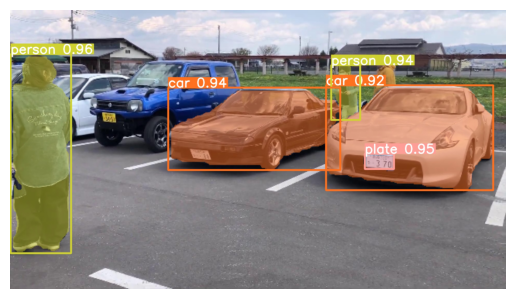

In [48]:
# 使用例
model_path = "./runs/train/weights/best.pt"
image_path = '../Grounded-Segment-Anything/outputs/images/test/Aomori inakadate Spring Car Meet 2023 mnvV9s4L9MA_frame_3816.jpg'
predict_and_save_images(model_path, image_path)